In [1]:
from matplotlib import pyplot as plt

import xarray as xr
import netCDF4 as nc
import numpy as np

import os

import datetime as dt
import pickle

from sklearn.model_selection import train_test_split
from sklearn.linear_model import RidgeCV, Ridge, LinearRegression, Lasso, ElasticNet
from sklearn.kernel_ridge import KernelRidge
from sklearn.metrics import r2_score
import random
from tqdm import tqdm
from collections import Counter

In [2]:
RidgeCV?

Init signature:
RidgeCV(
    alphas=(0.1, 1.0, 10.0),
    *,
    fit_intercept=True,
    scoring=None,
    cv=None,
    gcv_mode=None,
    store_cv_values=False,
    alpha_per_target=False,
)
Docstring:     
Ridge regression with built-in cross-validation.

See glossary entry for :term:`cross-validation estimator`.

By default, it performs efficient Leave-One-Out Cross-Validation.

Read more in the :ref:`User Guide <ridge_regression>`.

Parameters
----------
alphas : array-like of shape (n_alphas,), default=(0.1, 1.0, 10.0)
    Array of alpha values to try.
    Regularization strength; must be a positive float. Regularization
    improves the conditioning of the problem and reduces the variance of
    the estimates. Larger values specify stronger regularization.
    Alpha corresponds to ``1 / (2C)`` in other linear models such as
    :class:`~sklearn.linear_model.LogisticRegression` or
    :class:`~sklearn.svm.LinearSVC`.
    If using Leave-One-Out cross-validation, alphas must be posi

In [5]:
models = ['CanESM5', 'MIROC-ES2L', 'MPI-ESM1-2-LR', 'MIROC6', 'CESM2']

In [6]:
def load_model_data(model, var, path='../data/'):
    # Loading data file
    file_path = os.path.join(path, '{}_{}.nc'.format(model, var))
    ds = xr.open_dataset(file_path)
    # Getting TAS
    tas_array = ds[var].values
    # Close the dataset
    ds.close()
    return tas_array

def get_data_shape_lat_lon(model='CanESM5', var='tas', path='../data/'):
    file_path = os.path.join(path, '{}_{}.nc'.format(model, var))
    ds = xr.open_dataset(file_path)
    # Getting TAS
    shape = ds[var].values.shape
    # Close the dataset
    ds.close()
    return shape, ds['lat'], ds['lon']

def load_data_models(models, var='tas', n_sample=10, path='../data/'):
    X, y = None, None
    for model in models:
        tas_array = load_model_data(model, var=var, path=path)
        shape = tas_array.shape
        
        idxs = random.sample(range(shape[0]*shape[1]), n_sample)
        X_temp = tas_array.reshape(shape[0]*shape[1], shape[2]*shape[3])
        y_temp = np.tile(tas_array.mean(axis=0), (shape[0], 1, 1)) .reshape(shape[0]*shape[1], shape[2]*shape[3])

        if X is None:
            X = X_temp[idxs,:]
            y = y_temp[idxs,:]
        else :
            X = np.vstack((X, X_temp[idxs,:]))
            y = np.vstack((y, y_temp[idxs,:]))
        del tas_array
        del X_temp
        del y_temp
    return X, y

In [7]:
shape, lat, lon = get_data_shape_lat_lon()
d = shape[2]*shape[3]

In [8]:
B = 20
models_test = random.choices(models, k=B)
models_train = [[model for model in models if model != model_test ] for model_test in models_test ]

In [9]:
occurence_models_test = Counter(models_test)

In [10]:
occurence_models_test

Counter({'MIROC6': 5,
         'MIROC-ES2L': 4,
         'CanESM5': 5,
         'MPI-ESM1-2-LR': 3,
         'CESM2': 3})

In [11]:
N = 2500
n_alpha = 10
alphas = np.logspace(2, 7, n_alpha)

In [9]:
n_cv = 5
weights = {model: None for model in models}
for i in tqdm(range(len(models_test))):
    m_train, m_test = models_train[i], models_test[i]
    #print('Fitting optimal ridge {}/{}'.format(i, B))
    print("Extracting data...", end='\r')
    X_train, Y_train = load_data_models(m_train, n_sample=N)
    X_test, Y_test = load_data_models([m_test], n_sample=N)
    print("Data extracted!")
    
    #idx = random.choices([0, 1, 2, 3])[0]
    #idx_val = list(range(idx*N, (idx+1)*N))
    #idx_train = list(list(range(0, idx*N))+ list(range(idx*N, 4*N)))
    print("Training ridge regression...", end='\r')
    ridge = RidgeCV(alphas=alphas, cv=n_cv) #cv=zip(idx_val, idx_val))
    ridge.fit(X_train, Y_train)
    print("Ridge regression fitted!")
    print('Saving weights...', end='\r')
    if weights[m_test] is None:
        weights[m_test] = np.hstack((ridge.coef_/occurence_models_test[m_test], (ridge.intercept_/occurence_models_test[m_test])[:,None]))
    else:
        weights[m_test] += np.hstack((ridge.coef_/occurence_models_test[m_test], (ridge.intercept_/occurence_models_test[m_test])[:,None]))
    print("Weights saved!")
# Save the weights for this alpha to a file
file_path = f'../weights/Ridge_weights_stability_n{N}.pkl'
with open(file_path, 'wb') as f:
    pickle.dump(weights, f)

  0%|                                                                 | 0/20 [00:00<?, ?it/s]/home/homer/.local/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=2.67985e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)
/home/homer/.local/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=1.95423e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)
/home/homer/.local/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=1.86105e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)
/home/homer/.local/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=1.89552e-08): result may not be accurate.
  dual_coef = linalg.solv

 30%|███████████████                                   | 6/20 [4:56:37<12:25:57, 3196.95s/it]/home/homer/.local/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=2.95074e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)
/home/homer/.local/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=3.03247e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)
/home/homer/.local/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=3.24232e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)
/home/homer/.local/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=3.23407e-08): result may not be accurate.
  dual_coef = linalg.solv

/home/homer/.local/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=1.88647e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)
/home/homer/.local/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=1.92705e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)
/home/homer/.local/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=1.92283e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)
 65%|███████████████████████████████▊                 | 13/20 [12:01:35<6:59:11, 3593.04s/it]/home/homer/.local/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=2.21232e-08): result may not be accurate.
  dual_coef = linalg.solv

 95%|████████████████████████████████████████████████▍  | 19/20 [17:03:41<50:18, 3018.07s/it]/home/homer/.local/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=1.99812e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)
/home/homer/.local/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=1.7702e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)
/home/homer/.local/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=1.71407e-08): result may not be accurate.
  dual_coef = linalg.solve(K, y, sym_pos=True, overwrite_a=False)
/home/homer/.local/lib/python3.10/site-packages/sklearn/linear_model/_ridge.py:194: LinAlgWarning: Ill-conditioned matrix (rcond=1.76254e-08): result may not be accurate.
  dual_coef = linalg.solve

In [12]:
directory = '../weights/'
file = 'Ridge_weights_stability_n2500.pkl'
with open(directory + file, 'rb') as f:
    weights = pickle.load(f)

In [13]:
R = 20
scores = {model:[] for model in models}
scores_pattern = np.zeros(d)
for b in tqdm(range(R)):
    for model in models:
        X_test, Y_test = load_data_models([model], var='tas')
        A, B = weights[model][:,:-1], weights[model][:,-1]
        Y_pred = X_test @ A.T + B 
        score_pattern = r2_score(Y_test, Y_pred, multioutput='raw_values')
        scores_pattern += score_pattern/(len(models)*R)
        scores[model].append(score_pattern.mean())


  0%|          | 0/20 [00:00<?, ?it/s]

  5%|▌         | 1/20 [01:18<24:54, 78.66s/it]


KeyboardInterrupt: 

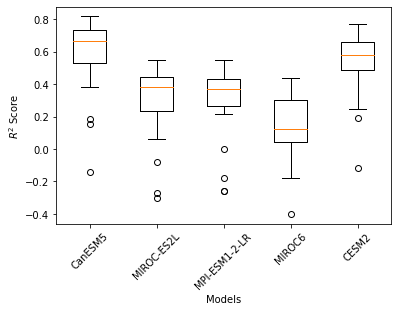

In [11]:
plt.boxplot([scores[model] for model in models])
# Boxplot
# Set xticklabels with alpha values
plt.xticks(range(1, len(models) + 1), [model for model in models], rotation=45)

# Set xlabel with alphas
plt.xlabel(r'Models')

# Set ylabel with r2 score
plt.ylabel(r'$R^2$ Score')

plt.show()

plt.show()

In [12]:
scores_pattern_maps = score_pattern.reshape(len(lat), len(lon))

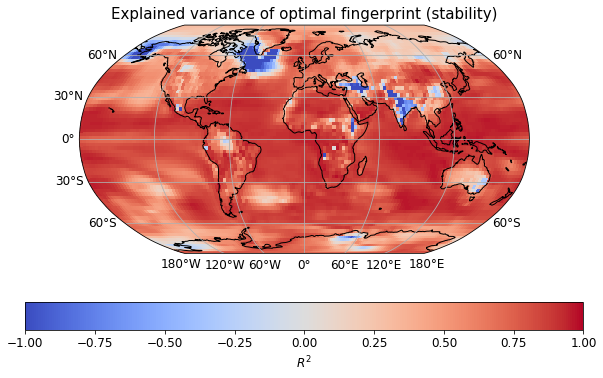

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from cartopy.mpl.gridliner import LONGITUDE_FORMATTER, LATITUDE_FORMATTER
from matplotlib.colors import TwoSlopeNorm

# Assuming you have defined lat, lon, diff_r2_map, diff_corr_map, max_val_r2, max_val_corr

# Plotting
fig = plt.figure(figsize=(10, 6))
ax = plt.axes(projection=ccrs.Robinson())

# Plot for diff_r2_map
norm_r2 = TwoSlopeNorm(vmin=-1.0, vcenter=0., vmax=1.0)
contour_r2 = ax.pcolormesh(lon, lat, scores_pattern_maps, transform=ccrs.PlateCarree(), cmap='coolwarm', norm=norm_r2)
ax.coastlines()

gl = ax.gridlines(draw_labels=True)
gl.top_labels = gl.right_labels = False
gl.xformatter = LONGITUDE_FORMATTER
gl.yformatter = LATITUDE_FORMATTER
gl.xlabel_style = {'size': 12}  # Longitude font size
gl.ylabel_style = {'size': 12}  # Latitude font size

ax.set_title(r'Explained variance of optimal fingerprint (stability)', fontsize=15)

cb = plt.colorbar(contour_r2, ax=ax, label='R2 score differences', orientation='horizontal')
cb.ax.tick_params(labelsize=12)
cb.set_label(r'$R^2$ ', fontsize=12) 

directory = '../Results'
plt.savefig(directory + "/maps_R2_ridge_stability.pdf", format="pdf", bbox_inches="tight")


plt.show()